In [1]:
import pandas as pd
import numpy as np
from IPython.display import display
import random
from sklearn.model_selection import LeaveOneOut
from sklearn.linear_model import LinearRegression, LogisticRegression
import random
from sklearn.metrics import recall_score, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from IPython.display import display
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

In [2]:
tagsFile = "tags"
recipesFile = "recipes"
nutritionsFile = "nutritions"
ingredientsFile = "ingredients"

tagsdf = pd.read_csv(f"/data/foodboost/{tagsFile}.csv", index_col=0)
recipesdf = pd.read_csv(f"/data/foodboost/{recipesFile}.csv", index_col=0)

In [3]:
def recepten_bij_tag(tag):
    a = tagsdf.loc[tagsdf['tag'] == tag].recipe.to_list()
    return a
def tags_bij_recept(gerecht):
    b = tagsdf.loc[tagsdf['recipe'] == gerecht].tag.unique()
    return b

In [4]:
for i in range(10):
    print(random.choices(tagsdf["tag"].to_list()))

['bijgerecht']
['hoofdgerecht']
['kinderrecepten']
['engels']
['lactosevrij']
['oven']
['wat eten we vandaag']
['hoofdgerecht']
['budget']
['italiaans']


In [5]:
def User_Favo_Random_Tags(randomTag = random.choices(tagsdf["tag"].to_list(), k=1), K=10):
    while len(recepten_bij_tag(randomTag[0])) < K:
        randomTag = random.choices(tagsdf["tag"].to_list(), k=1)
    
    #Lekker
    print('lengte recipes lijst lekker: ' + str(len(recepten_bij_tag(randomTag[0]))))
    RandomReceptenVoorTag = random.choices(recepten_bij_tag(randomTag[0]), k= K)
    Train_Favorieten, Test_Favorieten = RandomReceptenVoorTag[:int(K*0.8)], RandomReceptenVoorTag[int(K*0.8):]
    
    UserList_Tags = [tags_bij_recept(x) for x in Train_Favorieten]
    
    #Niet lekker
    #Niet lekker OFWEL RANDOM DIE NIET MET FAVOTAG TE MAKEN HEBBEN
    #Niet_Favo_df = [x for x in recipesdf["title"] if x not in np.array(recepten_bij_tag(randomTag[0]))]
    Niet_Favo_df = list(set(recipesdf["title"].to_list()).difference(recepten_bij_tag(randomTag[0])))
    Niet_Lekker_Recepten_Voor_Tag = random.choices(Niet_Favo_df, k= K)
    Train_Favorieten_Niet_Lekker, Test_Favorieten_Niet_Lekker = Niet_Lekker_Recepten_Voor_Tag[:int(K*0.8)], Niet_Lekker_Recepten_Voor_Tag[int(K*0.8):]
    
    Train_Favorieten_Niet_Lekker_Tags = [tags_bij_recept(x) for x in Train_Favorieten_Niet_Lekker]
    Test_Favorieten_Niet_Lekker_Tags = [tags_bij_recept(x) for x in Test_Favorieten_Niet_Lekker]
    #RandomRecepten = random.choices(recipesdf["title"].to_list(), k=int(K*0.8))
    
    #Random_Tags = [tags_bij_recept(x) for x in RandomRecepten]


    return Train_Favorieten, UserList_Tags, Train_Favorieten_Niet_Lekker_Tags, Train_Favorieten_Niet_Lekker, randomTag, K, Test_Favorieten, Test_Favorieten_Niet_Lekker_Tags

In [6]:
NumberOfUsers = 500
NumberOfRecipes = 20
UsersList = []
for i in range(NumberOfUsers):
    UserList, UserList_Tags, randomTags, randomRecipes, Usertag, K, Test_Favorieten, Test_Favorieten_Niet_Lekker_Tags = User_Favo_Random_Tags(randomTag = random.choices(tagsdf["tag"].to_list(), k=1), K=NumberOfRecipes)
    User = np.array([UserList, UserList_Tags, randomTags, randomRecipes, Usertag, K, Test_Favorieten, Test_Favorieten_Niet_Lekker_Tags])
    UsersList.append(User)

ListSize = len(UsersList)
TrainUsers, ValidateUsers, TestUsers = UsersList[:int(ListSize*0.6)], UsersList[int(ListSize*0.6): int(ListSize*0.8)], UsersList[int(ListSize*0.8):]

lengte recipes lijst lekker: 423
lengte recipes lijst lekker: 4595
lengte recipes lijst lekker: 505


/tmp/ipykernel_14444/1179687906.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  User = np.array([UserList, UserList_Tags, randomTags, randomRecipes, Usertag, K, Test_Favorieten, Test_Favorieten_Niet_Lekker_Tags])


lengte recipes lijst lekker: 717
lengte recipes lijst lekker: 114
lengte recipes lijst lekker: 4595
lengte recipes lijst lekker: 1291
lengte recipes lijst lekker: 216
lengte recipes lijst lekker: 1071
lengte recipes lijst lekker: 620
lengte recipes lijst lekker: 1923
lengte recipes lijst lekker: 2768
lengte recipes lijst lekker: 1250
lengte recipes lijst lekker: 482
lengte recipes lijst lekker: 1588
lengte recipes lijst lekker: 2768
lengte recipes lijst lekker: 1277
lengte recipes lijst lekker: 1923
lengte recipes lijst lekker: 437
lengte recipes lijst lekker: 627
lengte recipes lijst lekker: 1435
lengte recipes lijst lekker: 83
lengte recipes lijst lekker: 1679
lengte recipes lijst lekker: 4595
lengte recipes lijst lekker: 573
lengte recipes lijst lekker: 557
lengte recipes lijst lekker: 762
lengte recipes lijst lekker: 1923
lengte recipes lijst lekker: 1588
lengte recipes lijst lekker: 2542
lengte recipes lijst lekker: 1679
lengte recipes lijst lekker: 1923
lengte recipes lijst lekke

In [7]:
list_of_tags = tagsdf['tag'].unique().tolist()

In [8]:
def fillInMatrix(matrix, column, index_counter, doDoubleRows, isY, columnPrefix = ""):
    size = len(column)
    if(type(column) == str):
        size = 1
    for i in range(size):
        matrix.loc[index_counter, columnPrefix + column[i]] = 1
        if(doDoubleRows):
            if(isY):
                matrix.loc[index_counter+1, columnPrefix + column[i]] = 0
            else:
                matrix.loc[index_counter+1, columnPrefix + column[i]] = 1

In [9]:
#TRAIN_Matrix
def generateTrainMatrix(UserList, randomTags, randomRecipes):
    
    matrix = pd.DataFrame(columns = list_of_tags)
    
    for i in range(len(UserList*2)):
        matrix.loc[matrix.shape[0]] = 0
    
    columnPrefix = "2-"
    matrix2 = matrix.copy()
    matrix2.columns = [columnPrefix + columnName for columnName in matrix2.columns]
    
    X = np.array(UserList)
    loo = LeaveOneOut()
    index_counter = 0

    for train_index, test_index in loo.split(X):
        X_train, X_test = X[train_index], X[test_index]

        randomTags0 = randomTags.pop(0)
        randomgerecht0 = randomRecipes.pop(0)

        X_train_tags_unique = np.unique(np.concatenate([tags_bij_recept(x) for x in X_train]))
        X_test_tags_unique = np.unique(np.concatenate([tags_bij_recept(x) for x in X_test]))

        #----- Matrix met train vullen
        fillInMatrix(matrix, X_train_tags_unique, index_counter, True, False)
        
        #Rij 1
        fillInMatrix(matrix2, X_test_tags_unique, index_counter, False, False, columnPrefix = columnPrefix)
        #print(matrix2)
        
        #Rij 2
        fillInMatrix(matrix2, randomTags0, index_counter+1, False, False, columnPrefix = columnPrefix)
        
        #Put the value for the random tag as 1 and put y at 0, because it should be false
        fillInMatrix(matrix2, 'y', index_counter, True, True)
        
        #Show which random tag is taken and the one out
        matrix2.loc[index_counter+1, 'Randomgerecht'] = str(randomgerecht0)
        matrix2.loc[index_counter, 'one out'] = X_test
        matrix2.loc[index_counter+1, 'one out'] = X_test
        
        index_counter += 2
    return pd.concat([matrix, matrix2], axis=1)

In [10]:
#TEST_Matrix
def generateTestMatrix(UserList, Test_Favorieten, Test_Favorieten_Niet_Lekker_Tags):
    matrix1 = pd.DataFrame(columns = list_of_tags)
    Gerechten = np.array(UserList)
    Test_Gerechten = np.array(Test_Favorieten)
    
    for i in range(len(Test_Gerechten) + len(Test_Favorieten_Niet_Lekker_Tags)):
        matrix1.loc[matrix1.shape[0]] = 0
    
    matrix2 = matrix1.copy()
    columnPrefix = "2-"
    matrix2.columns = [columnPrefix + columnName for columnName in matrix2.columns]
    
    #-----
    for index_counter in range(len(Test_Gerechten)):
        
        Gerecht_Tags = np.unique(np.concatenate([tags_bij_recept(x) for x in Gerechten]))
        Test_Gerecht_Tags = tags_bij_recept(Test_Gerechten[index_counter])

        #----- Matrix1 met Userlist (1-8) invullen
        fillInMatrix(matrix1, Gerecht_Tags, index_counter, False, False)

        #----- Matrix2 met Test_Favorieten (9-10) vullen
        fillInMatrix(matrix2, Test_Gerecht_Tags, index_counter, False, False, columnPrefix = columnPrefix)
    
    for p in range(len(Test_Gerechten), len(Test_Gerechten) + len(Test_Favorieten_Niet_Lekker_Tags)):
        #----- Matrix1 met Userlist (1-8) invullen
        fillInMatrix(matrix1, Gerecht_Tags, p, False, False)
        
        fillInMatrix(matrix2, Test_Favorieten_Niet_Lekker_Tags, p, False, False, columnPrefix = columnPrefix)
    return pd.concat([matrix1, matrix2], axis=1)

In [11]:
#--Dubbele Matrix Compleet
def testTrainMatrix():
    UserList, UserList_Tags, randomTags, randomRecipes, Usertag, K, Test_Favorieten, Test_Favorieten_Niet_Lekker_Tags = User_Favo_Random_Tags(K=NumberOfRecipes)
    VolledigeMatrix = generateTrainMatrix(UserList, randomTags, randomRecipes)
    return VolledigeMatrix

In [12]:
testTrainMatrix()

lengte recipes lijst lekker: 789


,hollands,gebak,sinterklaas,sinterklaasavond,oven,vooraf te maken,lactosevrij,thais,aziatisch,curry,...,2-valentijnsdag,2-zuid-afrikaans,2-koreaans,2-kidsfavoriet,2-diner,2-lente,2-jamie oliver,y,Randomgerecht,one out
0,1,0,1,1,1,1,1,0,0,0,...,0,0,0,0,0,0,0,1.0,NaN,[Olijvenbrood met truffelolie en parmezaan ]
1,1,0,1,1,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0.0,Bbq gegrilde avocado met salsa en zwarte bonen,[Olijvenbrood met truffelolie en parmezaan ]
2,1,0,1,1,1,1,1,0,0,0,...,0,0,0,0,0,0,0,1.0,NaN,[Zomerse pastabowl]
3,1,0,1,1,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0.0,Kleurrijke salade met broccolirijst en feta,[Zomerse pastabowl]
4,1,0,1,1,1,1,1,0,0,0,...,0,0,0,0,0,0,0,1.0,NaN,[Babybietjes met burrata en pistachenoten ]
5,1,0,1,1,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0.0,"Salade met penne rigate, peer en pancetta",[Babybietjes met burrata en pistachenoten ]
6,1,0,1,1,1,1,1,0,0,0,...,0,0,0,0,0,0,0,1.0,NaN,[Linzen met ovengroenten]
7,1,0,1,1,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0.0,Fudgewafels met vanille-ijs,[Linzen met ovengroenten]
8,1,0,1,1,1,1,1,0,0,0,...,0,0,0,0,0,0,0,1.0,NaN,[Börek met spinazie en feta]
9,1,0,1,1,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0.0,Gegrilde zalm met wortelsalade &amp; bieslookk...,[Börek met spinazie en feta]


In [13]:
def createTrainMatrix():
    Matrix = pd.DataFrame()
    for User in TrainUsers:
        UserList, randomTags, randomRecipes = User[0], User[2], User[3]
        TrainMatrix = generateTrainMatrix(UserList, randomTags, randomRecipes)
        Matrix = pd.concat([Matrix, TrainMatrix], axis=0, ignore_index=True)
    
    return Matrix

In [14]:
def createValidateMatrix():
    Matrix = pd.DataFrame()
    y_validate = []
    for User in ValidateUsers:
        UserList, randomTags, randomRecipes, Test_Favorieten, Test_Favorieten_Niet_Lekker_Tags = User[0], User[2], User[3], User[6], User[7]
        TestMatrix = generateTestMatrix(UserList, Test_Favorieten, Test_Favorieten_Niet_Lekker_Tags)
        Matrix = pd.concat([Matrix, TestMatrix], axis=0, ignore_index=True)
        
        for p in Test_Favorieten:
            y_validate.append(1)
        for t in Test_Favorieten_Niet_Lekker_Tags:
            y_validate.append(0)
    return Matrix, y_validate

In [15]:
def createTestMatrix():
    Matrix = pd.DataFrame()
    y_test = []
    for User in TestUsers:
        UserList, randomTags, randomRecipes, Test_Favorieten, Test_Favorieten_Niet_Lekker_Tags = User[0], User[2], User[3], User[6], User[7]
        TestMatrix = generateTestMatrix(UserList, Test_Favorieten, Test_Favorieten_Niet_Lekker_Tags)
        Matrix = pd.concat([Matrix, TestMatrix], axis=0, ignore_index=True)
        
        for p in Test_Favorieten:
            y_test.append(1)
        for t in Test_Favorieten_Niet_Lekker_Tags:
            y_test.append(0)
    return Matrix, y_test

In [16]:
# for i in range(NumberOfUsers):
#     UserList, UserList_Tags, randomTags, randomRecipes, Usertag, K, Test_Favorieten, Test_Favorieten_Niet_Lekker_Tags = User_Favo_Random_Tags(randomTag = random.choices(tagsdf["tag"].to_list(), k=1), randomTagNietLekker = random.choices(tagsdf["tag"].to_list(), k=1), K=NumberOfRecipes)
#     TrainMatrix = generateTrainMatrix(UserList, randomTags, randomRecipes)
#     TestMatrix = generateTestMatrix(UserList, Test_Favorieten, Test_Favorieten_Niet_Lekker_Tags)
#     TotalTrainMatrix = pd.concat([TotalTrainMatrix, TrainMatrix], axis=0, ignore_index=True)
#     TotalTestMatrix = pd.concat([TotalTestMatrix, TestMatrix], axis=0, ignore_index=True)
#     for p in Test_Favorieten:
#         y_test.append(1)
#     for t in Test_Favorieten_Niet_Lekker_Tags:
#         y_test.append(0)

In [17]:
TotalTrainMatrix = createTrainMatrix()
TotalValidateMatrix, y_validate = createValidateMatrix()
TotalTestMatrix, y_test = createTestMatrix()

In [18]:
TotalTrainMatrix

,hollands,gebak,sinterklaas,sinterklaasavond,oven,vooraf te maken,lactosevrij,thais,aziatisch,curry,...,2-valentijnsdag,2-zuid-afrikaans,2-koreaans,2-kidsfavoriet,2-diner,2-lente,2-jamie oliver,y,Randomgerecht,one out
0,1,0,0,0,1,1,1,0,0,0,...,0,0,0,0,0,0,0,1.0,NaN,[Ricottapannenkoekjes met honingboter &amp; pr...
1,1,0,0,0,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0.0,Botercrème (voor macarons),[Ricottapannenkoekjes met honingboter &amp; pr...
2,1,1,0,0,1,1,1,0,0,0,...,0,0,0,0,0,0,0,1.0,NaN,[Yoghurt met tuttifrutti en blauwe bessen]
3,1,1,0,0,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0.0,Eendenravioli met zachte eidooier en truffelsaus,[Yoghurt met tuttifrutti en blauwe bessen]
4,1,1,0,0,1,1,1,0,0,0,...,0,0,0,0,0,0,0,1.0,NaN,"[Yoghurtsmoothie met havermout, banaan en aard..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9595,0,1,0,0,1,1,1,0,1,0,...,0,0,0,0,0,0,0,0.0,Groene kool met kikkererwten,[Dukkah van Nadia en Merijn]
9596,0,1,0,0,1,1,1,0,1,0,...,0,0,0,0,0,0,0,1.0,NaN,[Guacamole basisrecept]
9597,0,1,0,0,1,1,1,0,1,0,...,0,0,0,0,0,0,0,0.0,Filetlapjes met parmaham en salie,[Guacamole basisrecept]
9598,0,1,0,0,1,1,1,0,1,0,...,0,0,0,0,0,0,0,1.0,NaN,[Broccolistronk-pickles]


In [19]:
#--Dubbele Matrix
X_train = TotalTrainMatrix.drop(['y', 'Randomgerecht', 'one out'], axis=1)
y_train = TotalTrainMatrix['y'].to_list()

In [20]:
TotalValidateMatrix_Values = TotalValidateMatrix.loc[:, (TotalValidateMatrix != 0).any(axis=0)]
#TotalValidateMatrix_Values
TotalValidateMatrix

,hollands,gebak,sinterklaas,sinterklaasavond,oven,vooraf te maken,lactosevrij,thais,aziatisch,curry,...,2-mealprep,2-slowcooker,2-oost-europees,2-valentijnsdag,2-zuid-afrikaans,2-koreaans,2-kidsfavoriet,2-diner,2-lente,2-jamie oliver
0,0,0,0,0,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
795,1,1,0,0,1,1,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
796,1,1,0,0,1,1,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
797,1,1,0,0,1,1,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
798,1,1,0,0,1,1,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [21]:
y_train

[1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0

In [22]:
AmountOfRows = X_train[X_train.columns[0]].count()
print(AmountOfRows)

9600


In [23]:
def RFC():
    model_rfc = RandomForestClassifier(min_samples_split=16, min_samples_leaf=4, min_weight_fraction_leaf=0.05)
    model_rfc.fit(X_train, y_train)
    y_pred = model_rfc.predict(TotalValidateMatrix)
    print(recall_score(y_validate, y_pred))
    print(confusion_matrix(y_true = y_validate, y_pred = y_pred))
    print(accuracy_score(y_validate, y_pred))

In [24]:
RFC()

0.6425
[[ 60 340]
 [143 257]]
0.39625


In [25]:
def testClassifiers():
    #---Modellen
    model_lr = LogisticRegression(max_iter=AmountOfRows+100)
    model_knn = KNeighborsClassifier()
    model_svm = SVC()
    model_rfc = RandomForestClassifier()
    
    parameters_lr = {'C': np.logspace(-5, 8, 15)}
    parameters_knn = {'n_neighbors': list(range(1, 10)),
                     'leaf_size' : list(range(1, 10)), 
                      'p':[1,2]}
    parameters_svm = {'C': [0.1, 1, 10, 100],  
                    'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
                    'gamma':['scale', 'auto']}
                    #'kernel': ['linear']}
    parameters_rfc = {'min_samples_split': [0,5,10,20],
                      'min_samples_leaf': [2,4,6,8,10],
                      'min_weight_fraction_leaf': [0.01, 0.05, 0.1]}
    
    #---Logistic Regression
    print("\nLogistic Regression")
    Grid_lr = GridSearchCV(model_lr, parameters_lr, cv=5)
    Grid_lr.fit(X_train, y_train)

    y_pred = Grid_lr.predict(TotalValidateMatrix)

    print("y_pred: ", y_pred)
    print("Tuned Logistic Regression Parameters: {}".format(Grid_lr.best_params_)) 
    print("Best score is {}".format(Grid_lr.best_score_))
    print("Confusion Matrix: ", confusion_matrix(y_true = y_validate, y_pred = y_pred))
    #print("Classification Report: ", classification_report(y_validate, y_pred))
    print("Accuracy Score: ", accuracy_score(y_validate, y_pred))
    print("Score: ", Grid_lr.score(TotalValidateMatrix, y_validate))

#---K_NearestNeighbors
    print("\nK_NearestNeighbors")
    Grid_knn = GridSearchCV(model_knn, parameters_knn, cv=5)
    Grid_knn.fit(X_train, y_train)

    y_pred = Grid_knn.predict(TotalValidateMatrix)

    print("y_pred: ", y_pred)
    print("Tuned K_NearestNeighbors Parameters: {}".format(Grid_knn.best_params_)) 
    print("Best score is {}".format(Grid_knn.best_score_))
    print("Confusion Matrix: ", confusion_matrix(y_true = y_validate, y_pred = y_pred))
    print("Accuracy Score: ", accuracy_score(y_validate, y_pred))
    print("Score: ", Grid_knn.score(TotalValidateMatrix, y_validate))

#---SVC
    print("\nSVM")
    Grid_svm = GridSearchCV(model_svm, parameters_svm, cv=5)
    Grid_svm.fit(X_train, y_train)

    y_pred = Grid_svm.predict(TotalValidateMatrix)

    print("y_pred: ", y_pred)
    print("Tuned SVM Parameters: {}".format(Grid_svm.best_params_)) 
    print("Best score is {}".format(Grid_svm.best_score_))
    print("Confusion Matrix: ", confusion_matrix(y_true = y_validate, y_pred = y_pred))
    print("Accuracy Score: ", accuracy_score(y_validate, y_pred))
    print("Score: ", Grid_svm.score(TotalValidateMatrix, y_validate))
    
#---RFC
    print("\nRFC")
    Grid_rfc = GridSearchCV(model_rfc, parameters_rfc, cv=5)
    Grid_rfc.fit(X_train, y_train)

    y_pred = Grid_rfc.predict(TotalValidateMatrix)

    print("y_pred: ", y_pred)
    print("Tuned RFC Parameters: {}".format(Grid_rfc.best_params_)) 
    print("Best score is {}".format(Grid_rfc.best_score_))
    print("Confusion Matrix: ", confusion_matrix(y_true = y_validate, y_pred = y_pred))
    print("Accuracy Score: ", accuracy_score(y_validate, y_pred))
    print("Score: ", Grid_rfc.score(TotalValidateMatrix, y_validate))

    print("====================================================================")

In [26]:
testClassifiers()


Logistic Regression
y_pred:  [1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1. 1. 1. 0. 1. 0. 1. 1. 1. 1.
 0. 0. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1.
 1. 0. 1. 0. 1. 1. 1. 1. 1. 0. 1. 0. 1. 1. 1. 1. 0. 0. 0. 1. 1. 1. 1. 1.
 0. 0. 1. 0. 1. 1. 1. 1. 1. 0. 0. 0. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1. 1.
 1. 0. 0. 0. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1. 1. 0. 0. 0. 1. 1. 1. 1. 1.
 0. 1. 1. 1. 1. 1. 1. 1. 0. 1. 0. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1.
 1. 1. 0. 0. 1. 1. 1. 1. 0. 1. 1. 0. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1.
 0. 0. 1. 0. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1.
 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1.
 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1. 1. 1.
 1. 0. 0. 0. 1. 1. 1. 1. 1. 0. 0. 0. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1.
 1. 0. 0. 0. 1. 1. 1.

/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
75 fits failed out of a total of 300.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
75 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 476, in fit
    trees = Parallel(
  File "/opt/jupyterhub/anaconda/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/opt

y_pred:  [1. 0. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 0. 0. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 0. 0. 0. 0.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 0. 1. 1. 1. 1.
 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1.
 0. 1. 1. 0. 1. 1. 1. 1. 1. 1. 0. 1. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0.
 1. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0.
 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1. 1. 1. 1. 1. 1. 1. 0. 1. 0. 0. 0. 0.
 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 1. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 1. 1. 1. 1. 1. 0. 0. 0. 1. 1. 1. 1.
 1. 1. 1. 1. 0. 0. 0. 0. 1. 0. 1. 1. 1. 1. 1. 1. 0. 1. 0. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0.
 1. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.
 1. 0. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0.
 0. 1. 1. 1. 0. 0. 0. 0. 1. 1. 0. 0. 1. 1.

In [27]:
# parameters = 10
# for i in range(1, parameters):
#     print("i ", i)
#     model = KNeighborsClassifier(n_neighbors = i)
#     model.fit(X_train, y_train)
#     y_pred = model.predict(TotalValidateMatrix)
#     #print(y_pred)
#     print(recall_score(y_validate, y_pred))
#     print(confusion_matrix(y_true = y_validate, y_pred = y_pred))
#     print(accuracy_score(y_validate, y_pred))
#     print("====================")

In [29]:
testClassifier = KNeighborsClassifier(leaf_size= 1, n_neighbors= 7, p= 1)
testClassifier.fit(X_train, y_train)
testYpred = testClassifier.predict(TotalTestMatrix)

print("y_pred: ", testYpred)
print("Confusion Matrix: ", confusion_matrix(y_true = y_test, y_pred = testYpred))
#print("Classification Report: ", classification_report(y_test, testYpred))
print("Accuracy Score: ", accuracy_score(y_test, testYpred))

y_pred:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 1. 0. 1. 1. 0. 0. 0. 0.
 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1.
 1. 1. 1. 1. 0. 0. 0. 0. 1. 0. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0.
 1. 1. 1. 1. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0.
 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0.
 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0.
 1. 1. 0. 1. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0.
 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 0. 1. 1. 0. 0. 0. 0.
 0. 1. 0. 1. 0. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0.
 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 0. 1. 1. 1. 1.
 1. 0. 0. 1. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0.
 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1.

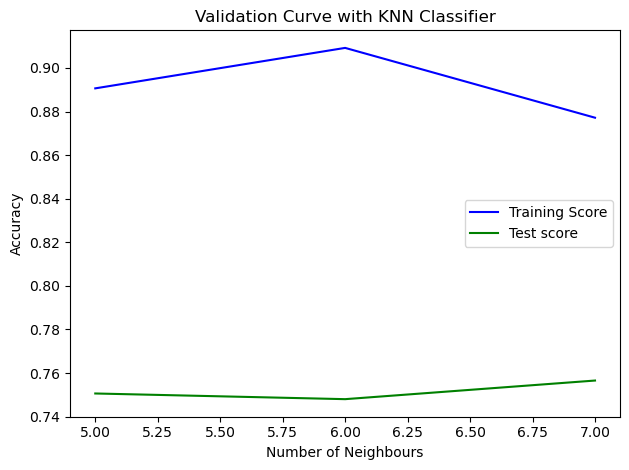

In [32]:
# Import Required libraries
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import load_digits
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import validation_curve


# Setting the range for the parameter (from 1 to 10)
parameter_range = np.arange(5, 8, 1)

# Calculate accuracy on training and test set using the
# gamma parameter with 5-fold cross validation
train_score, test_score = validation_curve(KNeighborsClassifier(leaf_size= 1, p= 1), X_train, y_train,
									param_name = "n_neighbors",
									param_range = parameter_range,
										cv = 5, scoring = "accuracy")

# Calculating mean and standard deviation of training score
mean_train_score = np.mean(train_score, axis = 1)
std_train_score = np.std(train_score, axis = 1)

# Calculating mean and standard deviation of testing score
mean_test_score = np.mean(test_score, axis = 1)
std_test_score = np.std(test_score, axis = 1)

# Plot mean accuracy scores for training and testing scores
plt.plot(parameter_range, mean_train_score,
	label = "Training Score", color = 'b')
plt.plot(parameter_range, mean_test_score,
label = "Test score", color = 'g')

# Creating the plot
plt.title("Validation Curve with KNN Classifier")
plt.xlabel("Number of Neighbours")
plt.ylabel("Accuracy")
plt.tight_layout()
plt.legend(loc = 'best')
plt.show()


In [30]:
# testClassifier = SVC(C= 100, gamma= 'auto')
# testClassifier.fit(X_train, y_train)
# testYpred = testClassifier.predict(TotalTestMatrix)

# print("y_pred: ", testYpred)
# print("Confusion Matrix: ", confusion_matrix(y_true = y_test, y_pred = testYpred))
# #print("Classification Report: ", classification_report(y_test, testYpred))
# print("Accuracy Score: ", accuracy_score(y_test, testYpred))

y_pred:  [0. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 0. 1. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0.
 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0.
 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0.
 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 0. 1. 0. 1. 1. 1. 1. 1. 1. 1. 0. 1. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0.
 0. 1. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0.
 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 1. 1. 1. 1.
 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0.
 1. 0. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1.